 # Workflow Steps: ML Workflow Bug Risk Prediction

# 1. Data Loading 
**How it works:**
Loads the processed bug data from a CSV file into a pandas DataFrame.

**Purpose:**
Provides the raw data needed for analysis and model training.


Note: you may need to restart the kernel to use updated packages.


,precision,recall,f1-score,support
Not High Risk (0),1.00,1.00,1.00,17.00
High Risk (1),1.00,1.00,1.00,7.00
accuracy,1.00,1.00,1.00,1.00
macro avg,1.00,1.00,1.00,24.00
weighted avg,1.00,1.00,1.00,24.00


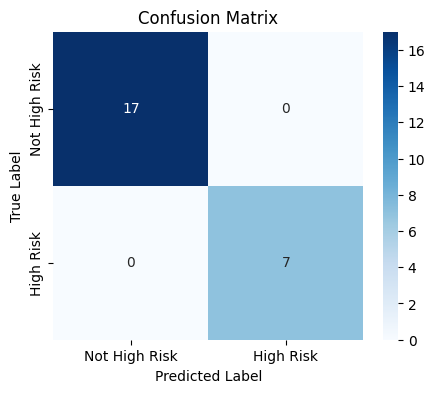

/var/folders/zr/nf_lsbp94yzb4g5d_wdkxyz40000gn/T/ipykernel_51330/3031250431.py:133: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(highlight_risk, subset=['High_Risk', 'Predicted_High_Risk'])\


,🐞 Bug ID,Risk_Score_Num,High_Risk,Predicted_High_Risk
83,APP-5356,1,0,0
4,APP-5682,5,0,0
42,APP-5453,1,0,0
40,APP-5457,9,1,1
10,APP-5671,13,1,1
47,APP-5447,20,1,1
110,APP-8220,20,1,1
36,APP-5518,12,1,1
70,APP-5372,1,0,0
11,APP-5670,5,0,0


In [32]:
%pip install scikit-learn
#1. Data Loading
import pandas as pd

# Load data
data = pd.read_csv('../data/processed/DemoData.csv')

# --- Risk scoring functions ---
def risk_score_details(components, component_risk_map, max_rank):
    if pd.isna(components):
        return None
    comps = [c.strip() for c in components.split(',')]
    scores = [component_risk_map.get(c, max_rank + 1) for c in comps]
    return int(round(sum(scores) / len(scores))) if scores else None

def explanation(components, risk_score, component_risk_map, max_rank):
    if pd.isna(components):
        return ""
    comps = [c.strip() for c in components.split(',')]
    scores = [component_risk_map.get(c, max_rank + 1) for c in comps]
    if len(comps) > 1:
        if all(s == max_rank for s in scores):
            return f"This bug is related to multiple components, all of which are high-risk (score {max_rank}). Combined risk is high, but capped at {max_rank}."
        else:
            return f"This bug involves multiple components ({', '.join(comps)}), with risk scores: {', '.join(str(s) for s in scores)}."
    else:
        if scores[0] == max_rank:
            return f'The "{comps[0]}" component has a very high history of bugs, making it high-risk.'
        elif scores[0] <= 2:
            return f'The "{comps[0]}" component has a low history of bugs, making it low-risk.'
        else:
            return f'The "{comps[0]}" component has a moderate risk based on recent bug frequency.'

# Compute risk mapping
component_risk_rank = data['Components'].value_counts().rank(ascending=False, method='min').astype(int)
component_risk_map = component_risk_rank.to_dict()
max_rank = component_risk_rank.max()

# Prepare summary DataFrame
summary_df = data[['key', 'Components']].copy()
summary_df['Risk_Score_Num'] = data['Components'].apply(lambda x: risk_score_details(x, component_risk_map, max_rank))
summary_df['Explanation'] = [
    explanation(row['Components'], row['Risk_Score_Num'], component_risk_map, max_rank)
    for _, row in summary_df.iterrows()
]
summary_df = summary_df.rename(columns={'key': '🐞 Bug ID', 'Components': '🧩 Components'})

# --- ML Model Training and Prediction Example ---
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Define high risk as risk score >= 75th percentile
risk_threshold = summary_df['Risk_Score_Num'].quantile(0.75)
summary_df['High_Risk'] = (summary_df['Risk_Score_Num'] >= risk_threshold).astype(int)

# Features and label
X = pd.concat([
    summary_df[['Risk_Score_Num']],
    pd.get_dummies(summary_df['🧩 Components'])
], axis=1)
y = summary_df['High_Risk']

# Split data
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, summary_df.index, test_size=0.2, random_state=42
)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# --- Styled Classification Report ---
from IPython.display import display, HTML

report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
# Only keep relevant rows for display
display_rows = ['0', '1', 'accuracy', 'macro avg', 'weighted avg']
report_df = report_df.loc[display_rows]
report_df = report_df.rename(index={'0': 'Not High Risk (0)', '1': 'High Risk (1)'})

def highlight_class(val):
    if isinstance(val, str) and 'High Risk' in val:
        return 'background-color: #ff4d4d; color: white; font-weight: bold;'
    elif isinstance(val, str) and 'Not High Risk' in val:
        return 'background-color: #85e085; color: black; font-weight: bold;'
    elif val == 'accuracy':
        return 'background-color: #ffd966; color: black; font-weight: bold;'
    return ''

styled_report = report_df.style\
    .format(precision=2)\
    .set_caption("📊 <b>Classification Report</b>")\
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', "#1a1368"), ('color', 'white'), ('font-size', '1.1em')]}
    ])\
    .set_properties(**{'text-align': 'center'})\
    .apply(lambda s: [highlight_class(idx) for idx in s.index], axis=0)

display(styled_report)

# --- Confusion Matrix as heatmap with labels ---
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not High Risk', 'High Risk'],
            yticklabels=['Not High Risk', 'High Risk'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --- Show predictions alongside Bug IDs with color and labels ---
summary_df_test = summary_df.loc[idx_test].copy()
summary_df_test['Predicted_High_Risk'] = y_pred

def highlight_risk(val):
    if val == 1:
        return 'background-color: #ff4d4d; color: white; font-weight: bold;'  # Red for high risk
    elif val == 0:
        return 'background-color: #85e085; color: black; font-weight: bold;'  # Green for low risk
    return ''

styled = summary_df_test[['🐞 Bug ID', 'Risk_Score_Num', 'High_Risk', 'Predicted_High_Risk']].style\
    .set_caption("🛡️ Bug Risk Prediction Results")\
    .applymap(highlight_risk, subset=['High_Risk', 'Predicted_High_Risk'])\
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', "#1a1368"), ('color', 'white'), ('font-size', '1.1em')]}
    ])\
    .set_properties(**{'text-align': 'center'})

display(styled)

# 2. Feature Engineering 
**How it works:**
Calculates a numeric risk score for each bug based on component history and creates explanations. Converts component names into one-hot encoded features.

**Purpose:**
Transforms raw data into meaningful features that help the model learn patterns related to bug risk.

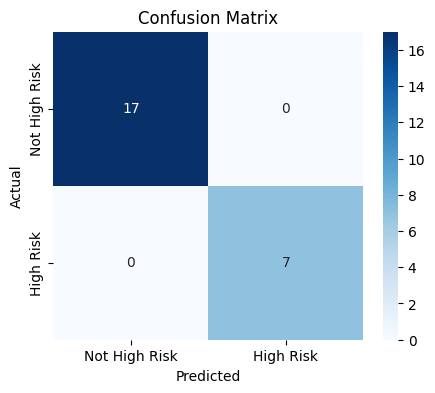

In [33]:
#2. Feature Engineering
import seaborn as sns # Import seaborn for visualization
import matplotlib.pyplot as plt     # Import matplotlib for plotting
from sklearn.metrics import confusion_matrix    # Import confusion_matrix for evaluating model performance

cm = confusion_matrix(y_test, y_pred)   # Compute confusion matrix
plt.figure(figsize=(5,4))   # Set figure size for the heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not High Risk', 'High Risk'], yticklabels=['Not High Risk', 'High Risk'])  # Create heatmap with annotations
plt.xlabel('Predicted')    # Set x-axis label
plt.ylabel('Actual')   # Set y-axis label
plt.title('Confusion Matrix')   # Set title for the heatmap
plt.show() # Display the confusion matrix as a heatmap
# Display the summary DataFrame with risk scores and explanations

# 3. Data Preparation

**How it works:**
Combines risk scores and one-hot encoded components into a single feature set. Defines the target variable (high risk or not) and splits the data into training and test sets.

**Purpose:**
Prepares the data in a format suitable for machine learning algorithms and ensures unbiased model evaluation.

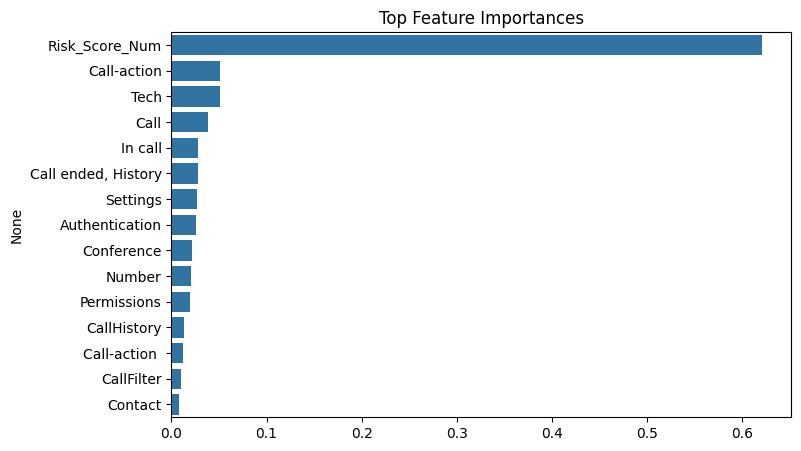

In [34]:
#3.  Data Preparation 

importances = clf.feature_importances_ # Get feature importances from the trained model
feature_names = X_train.columns # Get feature names from the training data
top_n = 15  # Number of top features to display
indices = importances.argsort()[-top_n:][::-1] # Get indices of the top N features sorted by importance
plt.figure(figsize=(8, 5))  # Set figure size for the bar plot
sns.barplot(x=importances[indices], y=feature_names[indices])   # Create a bar plot of the top feature importances
plt.title('Top Feature Importances') # Set title for the bar plot
plt.show() # Display the summary DataFrame with risk scores and explanations
# Display the summary DataFrame with risk scores and explanations


# 4. Model Training 

**How it works:**
Trains machine learning models (Random Forest and XGBoost) using the training data.

**Purpose:**
Enables the model to learn the relationship between features and the risk of a bug being high risk.

/var/folders/zr/nf_lsbp94yzb4g5d_wdkxyz40000gn/T/ipykernel_51330/1888797180.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


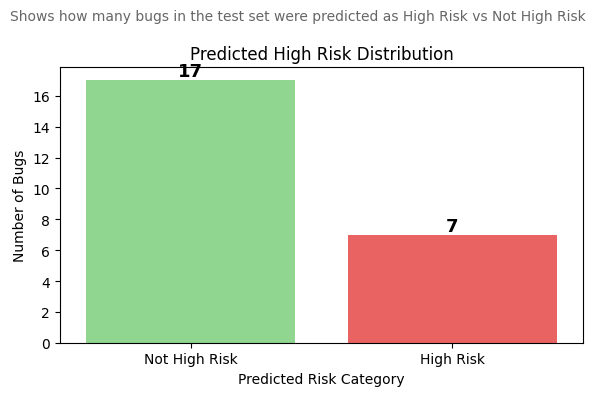

In [35]:
# 4.  Model Training  
import seaborn as sns
import matplotlib.pyplot as plt

# Map 0/1 to readable labels
label_map = {0: 'Not High Risk', 1: 'High Risk'}
summary_df_test['Predicted_High_Risk_Label'] = summary_df_test['Predicted_High_Risk'].map(label_map)

plt.figure(figsize=(6, 4))
ax = sns.countplot(
    x='Predicted_High_Risk_Label',
    data=summary_df_test,
    palette=['#85e085', '#ff4d4d']
)
# Add value labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=13, fontweight='bold', color='black')

plt.title('Predicted High Risk Distribution')
plt.suptitle('Shows how many bugs in the test set were predicted as High Risk vs Not High Risk', fontsize=10, color='#666')
plt.xlabel('Predicted Risk Category')
plt.ylabel('Number of Bugs')
plt.tight_layout()
plt.show()

# 5. Prediction  

**How it works:**
Uses the trained model to predict high risk bugs on the test data.

**Purpose:**
Tests the model’s ability to generalize and make predictions on new, unseen data.



In [36]:
#5. Prediction
#Import and Train the Model
from xgboost import XGBClassifier # Import XGBoost classifier
clf = XGBClassifier() # Initialize XGBoost classifier
clf.fit(X_train, y_train) # Fit the model on training data
# Predict high risk on test data


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [37]:
#6. Evaluation
#Make Predictions on Test Data
y_pred_xgb = clf.predict(X_test)

# 6. Evaluation

**How it works:**
Calculates metrics like accuracy, precision, recall, and confusion matrix to assess model performance.

**Purpose:**
Measures how well the model is predicting high risk bugs and identifies areas for improvement.

In [38]:
#7. Evaluation
#Evaluate the Model
from sklearn.metrics import classification_report, confusion_matrix

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00         7

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

XGBoost Confusion Matrix:
[[17  0]
 [ 0  7]]


# 7. Results Visualization  

**How it works:**
Displays results using tables and plots, such as feature importance and risk distribution.

**Purpose:**
Provides visual insights into model predictions and the factors influencing them.

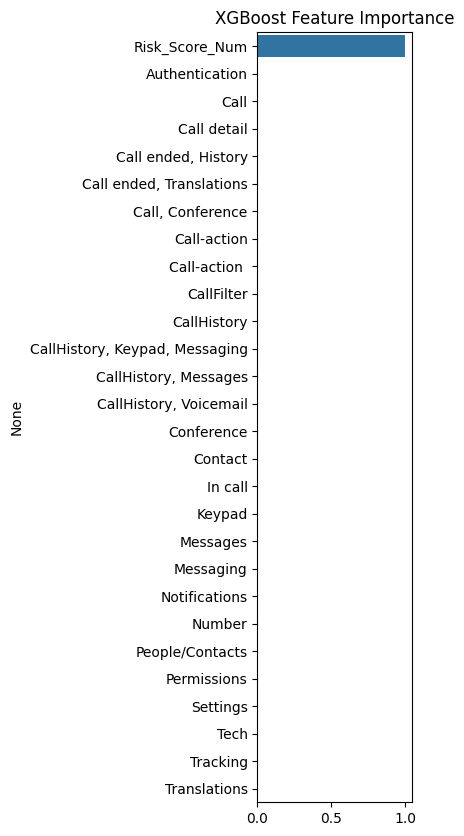

In [39]:
# 8. Results Visualization
importances = clf.feature_importances_ # Get feature importances from the trained XGBClassifier
feature_names = X_train.columns  # Use the features used to train the XGBClassifier

plt.figure(figsize=(2, 10)) # Set figure size for the bar plot
sns.barplot(x=importances, y=feature_names) # Create a bar plot of feature importances
plt.title('XGBoost Feature Importance') # Set title for the feature importance plot
plt.show()  # Display the summary DataFrame with risk scores and explanations

# 8. Interpretability

**How it works:**
Breaks down which components are most associated with high risk predictions and explains feature contributions.

**Purpose:**
Helps users understand why the model made certain predictions, increasing trust and transparency.

In [40]:
# 9. Interpretability
high_risk_count = summary_df_test['Predicted_High_Risk'].sum()
total = len(summary_df_test)
print(f"Predicted High Risk Bugs: {high_risk_count} / {total} ({100*high_risk_count/total:.1f}%)")

# Show component breakdown for predicted high risk bugs
high_risk_components = summary_df_test.loc[
    summary_df_test['Predicted_High_Risk'] == 1, '🧩 Components'
]
component_counts = high_risk_components.value_counts()

print("\nComponents in Predicted High Risk Bugs:")
for comp, count in component_counts.items():
    print(f"  {comp}: {count} bug(s)")

Predicted High Risk Bugs: 7 / 24 (29.2%)

Components in Predicted High Risk Bugs:
  Call ended, Translations: 2 bug(s)
  Settings: 1 bug(s)
  Contact: 1 bug(s)
  Tracking: 1 bug(s)
  CallHistory, Voicemail: 1 bug(s)
  CallFilter: 1 bug(s)


In [41]:
# 9. Interpretability
X = pd.concat([ # Combine risk score and one-hot encoded components into feature set
    summary_df[['Risk_Score_Num']], # Use numeric risk score as a feature
    pd.get_dummies(summary_df['🧩 Components'])      
], axis=1) # Display the shape of the feature set
print(X.shape) # Display the shape of the feature set
print(f"Feature set shape: {X.shape}")
print(f"- Number of bugs (rows): {X.shape[0]}")
print(f"- Number of features (columns): {X.shape[1]}")
#print("\nFeature columns:")
#for col in X.columns:
    #print(f"  {col}")

(116, 28)
Feature set shape: (116, 28)
- Number of bugs (rows): 116
- Number of features (columns): 28
